In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from numpy import linalg as LA
from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

%matplotlib inline

In [2]:
my_data = pd.read_csv('/home/lin/教材/MearchineLearning/assignmentOneData/48EqualWeighted.csv')

my_data['Unnamed: 0'] = pd.to_datetime(my_data['Unnamed: 0'])

print( np.unique(my_data['Unnamed: 0']).shape, my_data['Unnamed: 0'].shape)

my_data.set_index('Unnamed: 0', inplace = True)
N_ASSET = my_data.shape[1]
fiveY = my_data[-1250 :]
fiveY.shape

(12196,) (12196,)


(1250, 48)

### for features I will use mean-var, correlations. Theoretically, I can use 12K returns as 12K features for each asset, however, it is a extreme high dimentional problem, and even if you get the results, it is gonna be super difficult to interperate. OK I'll use 5 years returns as features too. In  K-means this is actually measure the the euclidean distance of the returns vectors so should expect the more similar the return series are, the closer they are so this should be similar to the correlation features result.

In [3]:
def get_feature_Matrices(data):
    meanVar = pd.DataFrame(columns=['mean', 'var'], index=data.columns, dtype=float)
    MI = pd.DataFrame(index=data.columns, columns=data.columns, dtype=float)

    for col in data.columns:
        meanVar['mean'][col] = data[col].mean()
        meanVar['var'][col] = data[col].var()
        for ref_col in data.columns:
            MI[ref_col][col] = metrics.mutual_info_score(data[ref_col], data[col])

    pearson = data.corr()
    kendall = data.corr(method='kendall')
    spearman = data.corr(method='spearman')
    
    return meanVar, pearson, kendall, spearman, MI


In [4]:
MV, corr, Ken, Spe, MI = get_feature_Matrices(fiveY)

In [5]:
normdFY = pd.DataFrame(columns=fiveY.columns, index=fiveY.index, dtype=float)
for col in fiveY:
    normdFY[col] = (fiveY[col] - MV['mean'][col]) / (MV['var'][col]**0.5)

## This is my own naive way

In [6]:
def choose_K(featureMa, plot=True, labelS=22, tS=22):
    
    sumDis = pd.DataFrame(columns=['sumDisSq', 'bm'], index=range(1, 49), dtype=float)
    bm = np.random.rand(featureMa.shape[0], featureMa.shape[1])
    for i in range(1, 49):

        kmeans = KMeans(n_clusters=i).fit(featureMa)
        sumDis['sumDisSq'][i] = kmeans.inertia_ 
        kmeansBM = KMeans(n_clusters=i).fit(bm)
        sumDis['bm'][i] = kmeansBM.inertia_ 
    print(abs(sumDis.diff()[abs(sumDis.diff()['sumDisSq']) > abs(sumDis.diff()['bm'])]))
    if plot:
        plt.plot(abs(sumDis.diff()), '-2')
        plt.legend(['data', 'benchmark'], fontsize=labelS)
        plt.xlabel('K', fontsize=labelS)
        plt.ylabel(r'absolute reduction in $\sum_{a=1}^{K} W(C_{a})$', fontsize=labelS)
        plt.title('K values vs reduction in loss function', fontsize=tS)
    return sumDis

Document of K-means  http://scikit-learn.org/stable/modules/clustering.html#k-means
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='k-means++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization, as shown in the reference.

n_init = 10

Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

The k-means problem is solved using Lloyd’s algorithm.

      sumDisSq        bm
2   104.416009  2.523902
3    18.022679  1.478245
4     3.322492  0.513086
5     1.881386  0.367665
6     0.976238  0.236135
7     0.485343  0.218780
8     0.375418  0.141807
9     0.237989  0.147785
10    0.175969  0.085390


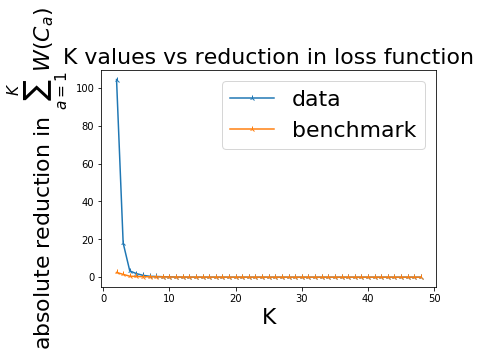

In [7]:
MVsumDis = choose_K(MV)

0
Index(['Soda', 'Beer', 'Smoke', 'Toys', 'Books', 'Clths', 'Hlth', 'Drugs',
       'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Steel', 'FabPr', 'Mach', 'ElcEq',
       'Autos', 'Aero', 'Ships', 'Guns', 'Mines', 'Telcm', 'PerSv', 'Comps',
       'Chips', 'Paper', 'Boxes', 'Trans', 'Rtail', 'RlEst', 'Other'],
      dtype='object')
1
Index(['Gold', 'Coal', 'Oil'], dtype='object')
2
Index(['Agric', 'Food', 'Fun', 'Hshld', 'MedEq', 'Cnstr', 'Util', 'BusSv',
       'LabEq', 'Whlsl', 'Meals', 'Banks', 'Insur', 'Fin'],
      dtype='object')


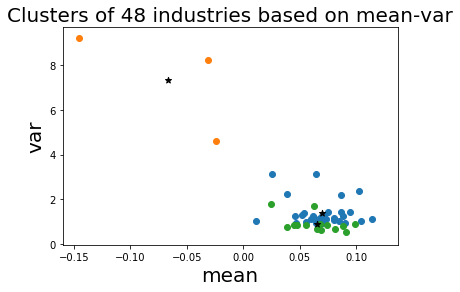

In [10]:
MVChoise = 3
kmeans = KMeans(MVChoise).fit(MV)
MV['cluster'] = kmeans.labels_ 
for j in range(MVChoise):
    print(j)
    print(MV[MV['cluster']==j].index)
    plt.scatter(MV['mean'][MV['cluster'] == j], MV['var'][MV['cluster'] == j])
    plt.scatter(kmeans.cluster_centers_[j][0], kmeans.cluster_centers_[j][1], marker='*', s=40, c='k')
    plt.xlabel('mean', fontsize=20)
    plt.ylabel('var', fontsize=20)
    plt.title('Clusters of 48 industries based on mean-var', fontsize=20)


    sumDisSq         bm
2  23.114297  11.351511
0
Index(['Food', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs',
       'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'Mach', 'ElcEq',
       'Autos', 'Aero', 'Ships', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips',
       'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks',
       'Insur', 'RlEst', 'Fin'],
      dtype='object')
1
Index(['Agric', 'Soda', 'Beer', 'Smoke', 'Toys', 'FabPr', 'Guns', 'Gold',
       'Mines', 'Coal', 'Oil', 'Util', 'Other'],
      dtype='object')


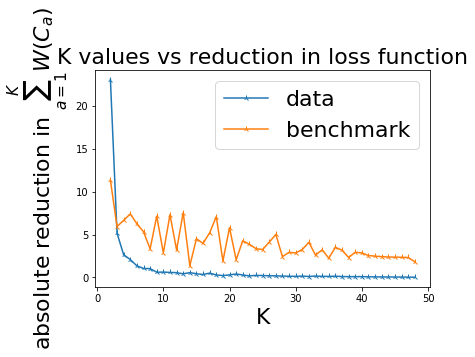

In [11]:
PearsonSumDis = choose_K(corr)
choise = 2
kmeans = KMeans(choise).fit(corr)
corr['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(corr[corr['cluster']==j].index)

    sumDisSq         bm
2  12.506596  10.195249
0
Index(['Food', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq',
       'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'Mach',
       'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Telcm', 'PerSv', 'BusSv',
       'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail',
       'Meals', 'Banks', 'Insur', 'RlEst', 'Fin', 'Other'],
      dtype='object')
1
Index(['Agric', 'Soda', 'Beer', 'Smoke', 'FabPr', 'Gold', 'Mines', 'Coal',
       'Oil', 'Util'],
      dtype='object')


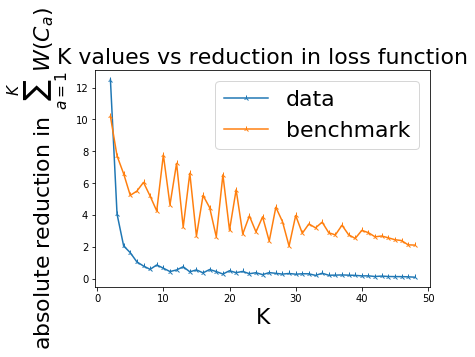

In [12]:
KenSumDis = choose_K(Ken)
choise = 2
kmeans = KMeans(choise).fit(Ken)
Ken['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(Ken[Ken['cluster']==j].index)

    sumDisSq         bm
2  18.879236  12.220583
0
Index(['Agric', 'Food', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth',
       'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel',
       'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Mines',
       'Oil', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper',
       'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst',
       'Fin', 'Other'],
      dtype='object')
1
Index(['Soda', 'Beer', 'Smoke', 'Gold', 'Coal', 'Util'], dtype='object')


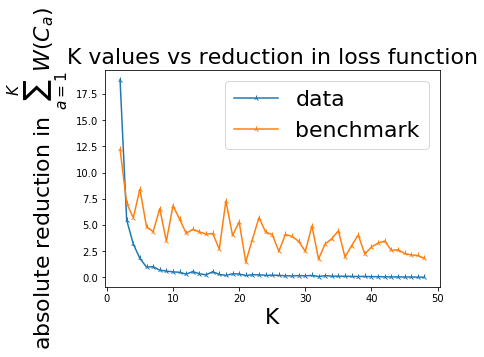

In [13]:
SpeSumDis = choose_K(Spe)
choise = 2
kmeans = KMeans(choise).fit(Spe)
Spe['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(Spe[Spe['cluster']==j].index)

    sumDisSq         bm
2  56.444886  11.580326
3  13.277245   7.352569
4   8.751291   6.485932
5   4.800012   4.468694
0
Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Chems', 'Rubbr', 'Txtls', 'BldMt',
       'Mach', 'ElcEq', 'Autos', 'Aero', 'Guns', 'Util', 'Telcm', 'PerSv',
       'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl',
       'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin', 'Other'],
      dtype='object')
1
Index(['Drugs', 'Cnstr', 'Steel', 'FabPr', 'Ships', 'Gold', 'Mines', 'Coal',
       'Oil'],
      dtype='object')


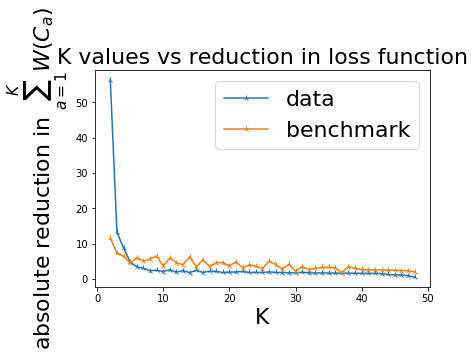

In [14]:
MISumDis = choose_K(MI)
choise = 2
kmeans = KMeans(choise).fit(MI)
MI['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(MI[MI['cluster']==j].index)

In [15]:
def hard_core_W(featureMa):
    
    newGroup = featureMa.groupby(by='cluster')
    DifW = 0.0
    for key, item in newGroup:
        oneClus = pd.DataFrame(newGroup.get_group(key), dtype=float).drop('cluster', axis=1)
        sumD = 0.0
        for asset1 in oneClus.index:
            vec1 = oneClus[oneClus.index==asset1]
            for asset2 in oneClus.index:
                vec2 = oneClus[oneClus.index==asset2]
                norm = LA.norm(np.asarray(vec1) - np.asarray(vec2))**2
                sumD = sumD + norm
        intoW = sumD/(oneClus.shape[0] * 2)
        DifW = DifW + intoW
    print(DifW)
#These two are the same thing, notes page 9


## This is using gap statistics

Gap paper


In [16]:
def gap_choose(featureMa, B=10):
    sumDis = pd.DataFrame(columns=['sumDisSq', 'bm', 'Elogbm', 'stBm', 'Gapk', 'sk'], index=range(1, 48), dtype=float)
    for i in range(1, 48):
        kmeans = KMeans(n_clusters=i).fit(featureMa)
        sumDis['sumDisSq'][i] = np.log(kmeans.inertia_)
        Wseries = pd.DataFrame(columns=['Wref'], index=range(B), dtype=float)

        for j in range(B):
            bm = pd.DataFrame(columns=featureMa.columns, index=featureMa.index, dtype=float)
            for col in featureMa.columns:
                up = max(featureMa[col])
                down = min(featureMa[col])
                ran = up - down
                bm[col] = np.random.rand(len(featureMa[col])) * ran + down
                
            kmeansBM = KMeans(n_clusters=i).fit(bm)
            Wseries['Wref'][j] = kmeansBM.inertia_
        sumDis['Elogbm'][i] = np.mean(np.log(Wseries['Wref']))
        sumDis['bm'][i] = np.mean(Wseries['Wref'])
        sumDis['stBm'][i] = np.std(np.log(Wseries['Wref']))

    sumDis['Gapk'] = sumDis['Elogbm'] - sumDis['sumDisSq']
    sumDis['sk'] = sumDis['stBm'] * (1 + 1 / B) ** 0.5
    sumDis['tocompare'] = (sumDis['Gapk'] - sumDis['sk']).shift(-1)
    return sumDis

In [17]:
def present_K_choice(sumMa, labelS=22, tS=22):
    plt.figure()
    plt.plot(np.exp(sumMa['sumDisSq']), '-2r')
    plt.plot(sumMa['bm'], '-2b')
    plt.legend(['data', 'benchmark'], fontsize=labelS)
    plt.xlabel('K', fontsize=labelS)
    plt.ylabel(r'$\sum_{a=1}^{K} W(C_{a})$', fontsize=labelS)
    plt.title('K values vs within sum of squares', fontsize=tS)
    
    plt.figure()
    plt.plot(sumMa['sumDisSq'], '-or')
    plt.plot(sumMa['Elogbm'], '-xb')
    plt.legend(['data', 'benchmark'], fontsize=labelS)
    plt.xlabel('K', fontsize=labelS)
    plt.ylabel(r'$logW_{k}$', fontsize=labelS)
    plt.title(r'K values vs $logW_{k}$', fontsize=tS)
    
    plt.figure()
    plt.plot(sumMa['Gapk'], 'r')
    plt.plot(sumMa['Gapk']+sumMa['sk'], '--g')
    plt.plot(sumMa['Gapk']-sumMa['sk'], '--g')
    plt.legend(['Gap'], fontsize=labelS)
    plt.xlabel('K', fontsize=labelS)
    plt.ylabel('Gaps', fontsize=labelS)
    plt.title('Gaps of different K values', fontsize=tS)

In [18]:
MV, corr, Ken, Spe, MI = get_feature_Matrices(fiveY)

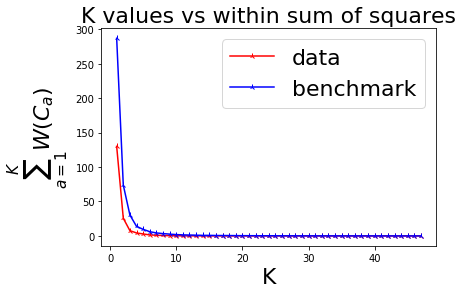

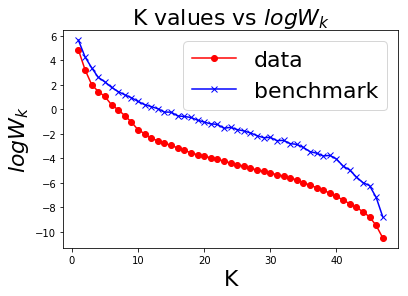

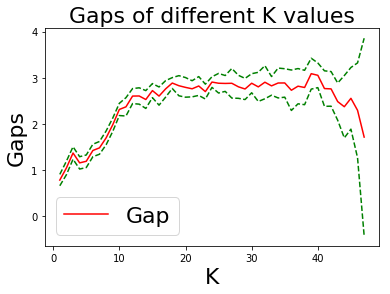

In [19]:
sumMV = gap_choose(MV)
present_K_choice(sumMV)

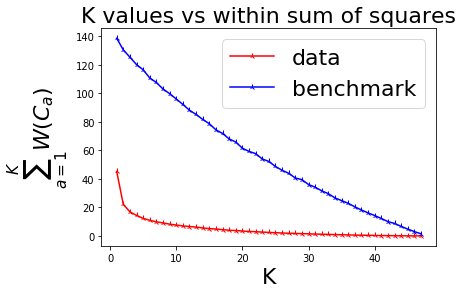

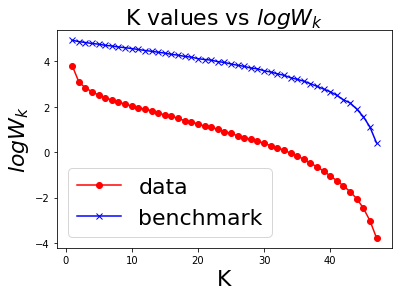

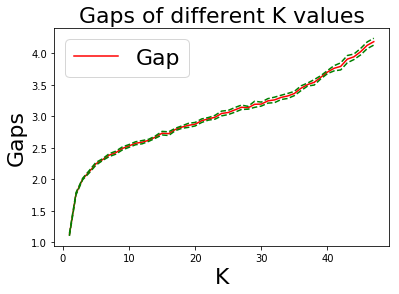

In [20]:
sumPear = gap_choose(corr)
present_K_choice(sumPear)

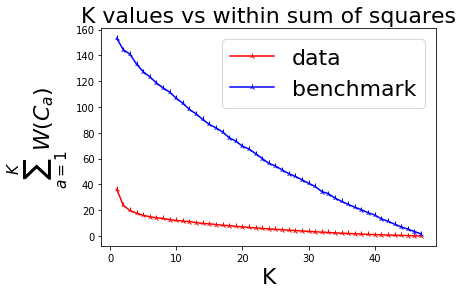

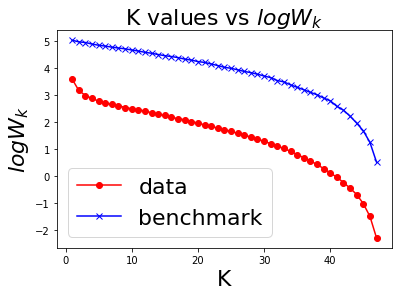

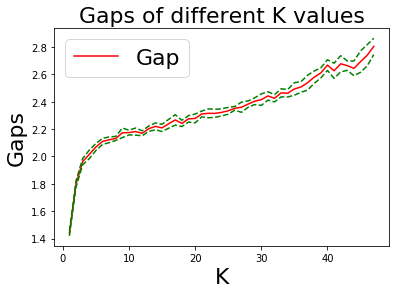

In [21]:
sumKen = gap_choose(Ken)
present_K_choice(sumKen)

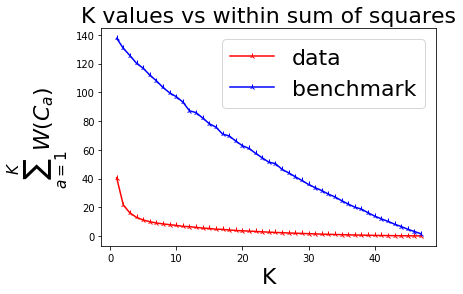

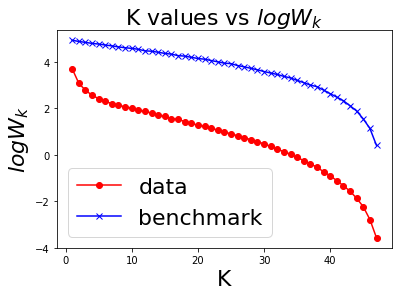

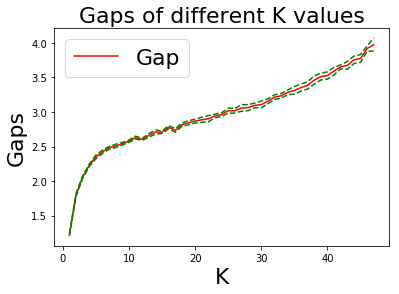

In [22]:
sumSpe = gap_choose(Spe)
present_K_choice(sumSpe)

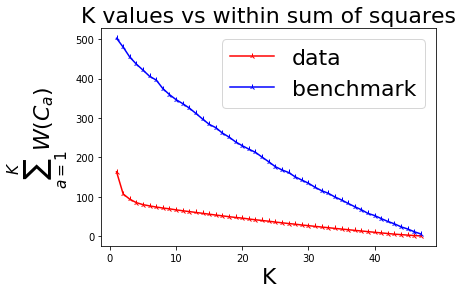

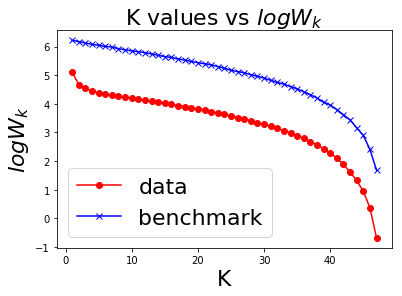

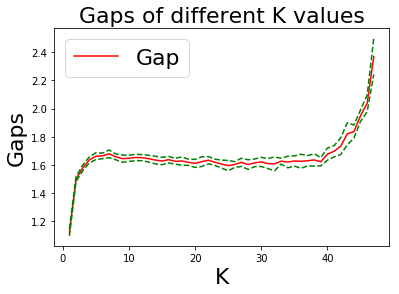

In [23]:
sumMI = gap_choose(MI)
present_K_choice(sumMI)

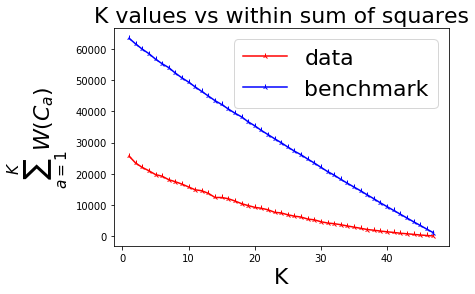

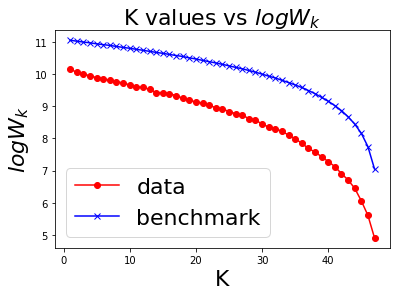

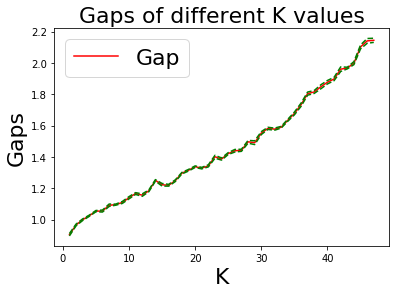

In [25]:
sumRe = gap_choose(normdFY.T)
present_K_choice(sumRe)

## This is using silhouette statistics

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

For n_clusters = 2 The average silhouette_score is : 0.8949537815803472
For n_clusters = 3 The average silhouette_score is : 0.769771428665921
For n_clusters = 4 The average silhouette_score is : 0.7225139422954374
For n_clusters = 5 The average silhouette_score is : 0.537855522685739
For n_clusters = 6 The average silhouette_score is : 0.5675401249278238


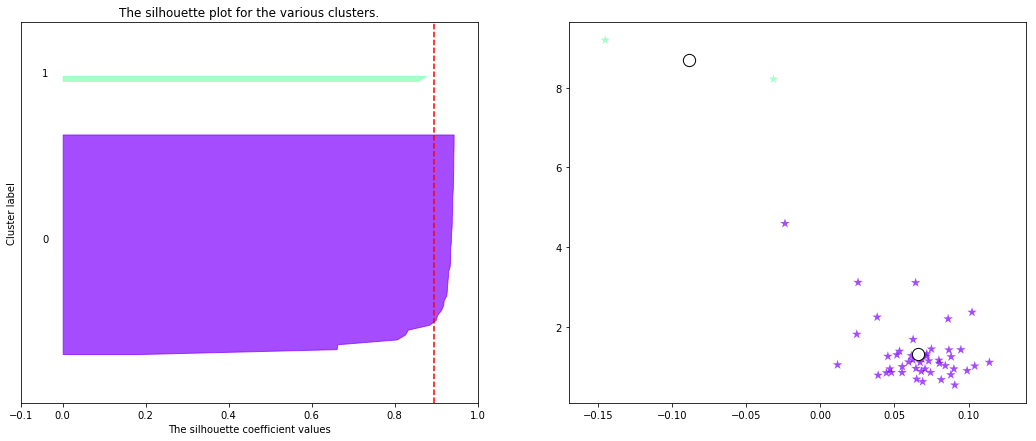

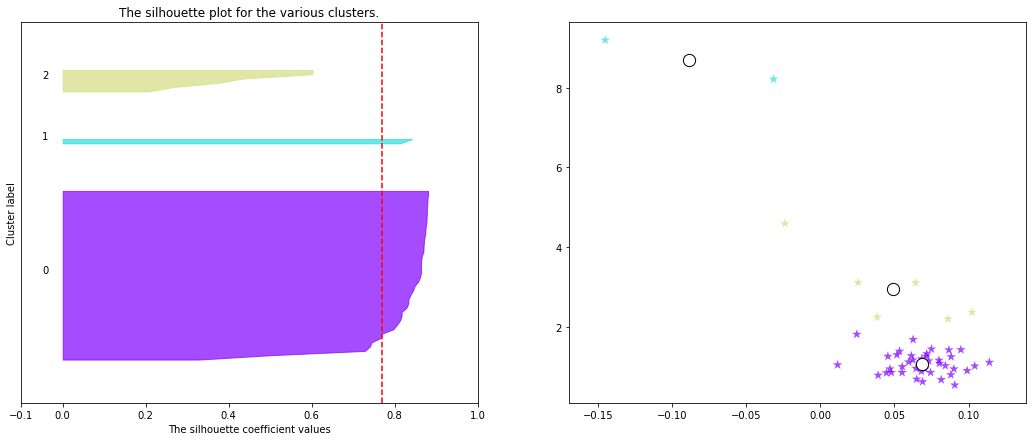

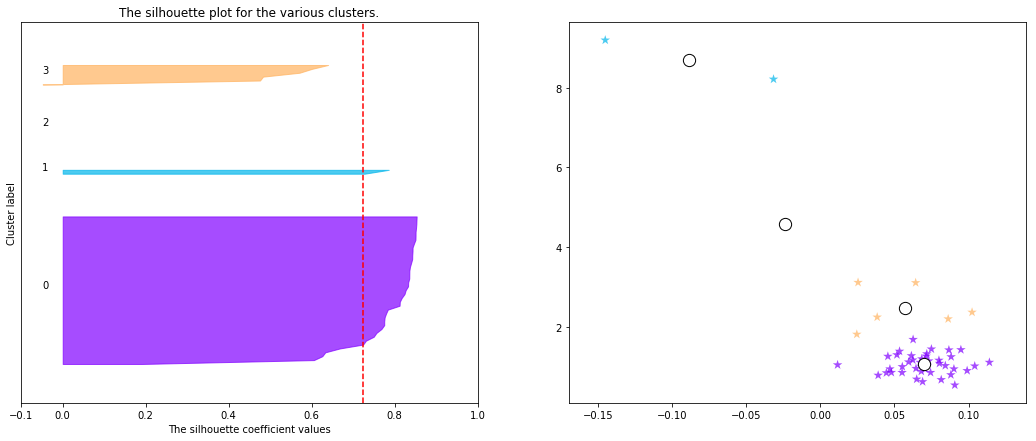

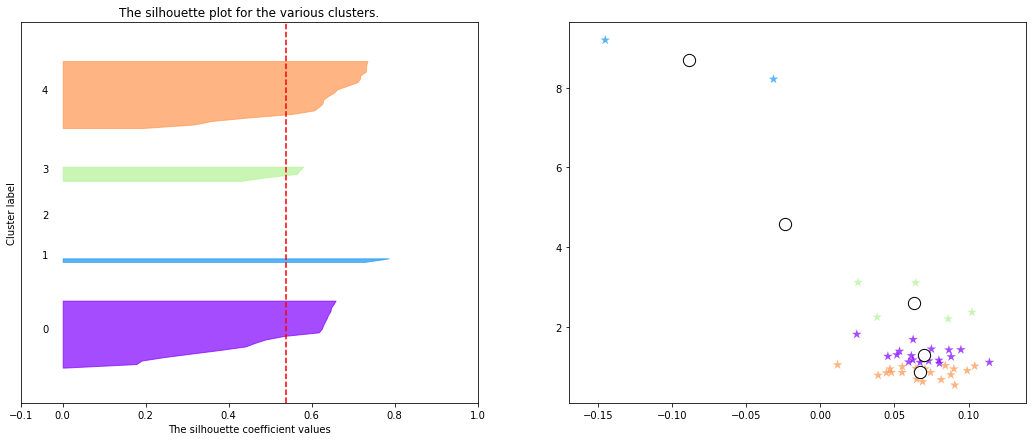

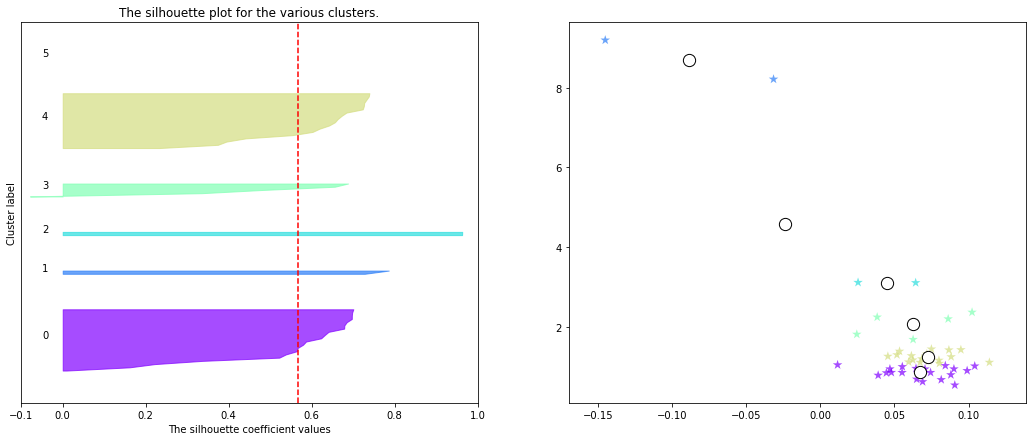

In [28]:
X=MV
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.values[:, 0], X.values[:, 1], marker='*', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=150, edgecolor='k')


In [29]:

def plot_silhouette(X, range_n_clusters):

    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)


        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


        clusterer = KMeans(n_clusters=n_clusters, random_state=None)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):

            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.rainbow(float(i)/n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  


For n_clusters = 2 The average silhouette_score is : 0.8949537815803472
For n_clusters = 3 The average silhouette_score is : 0.769771428665921
For n_clusters = 4 The average silhouette_score is : 0.7225139422954374
For n_clusters = 5 The average silhouette_score is : 0.537855522685739
For n_clusters = 6 The average silhouette_score is : 0.5675401249278238


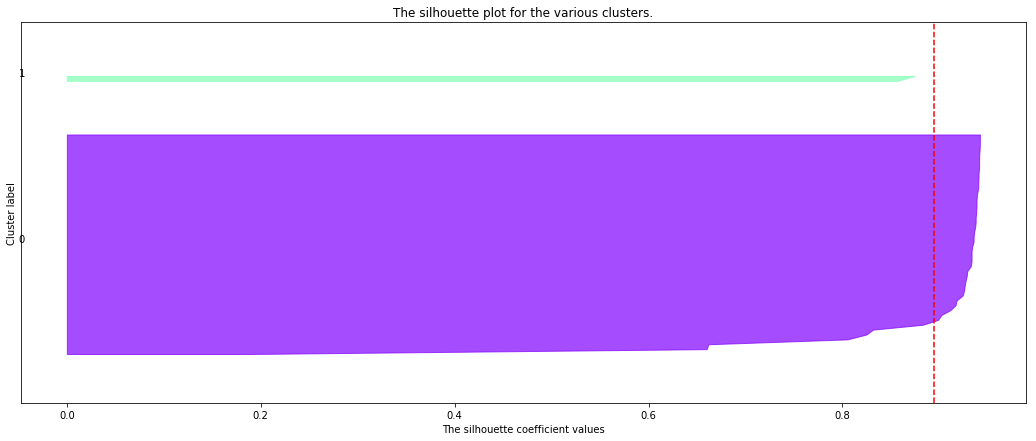

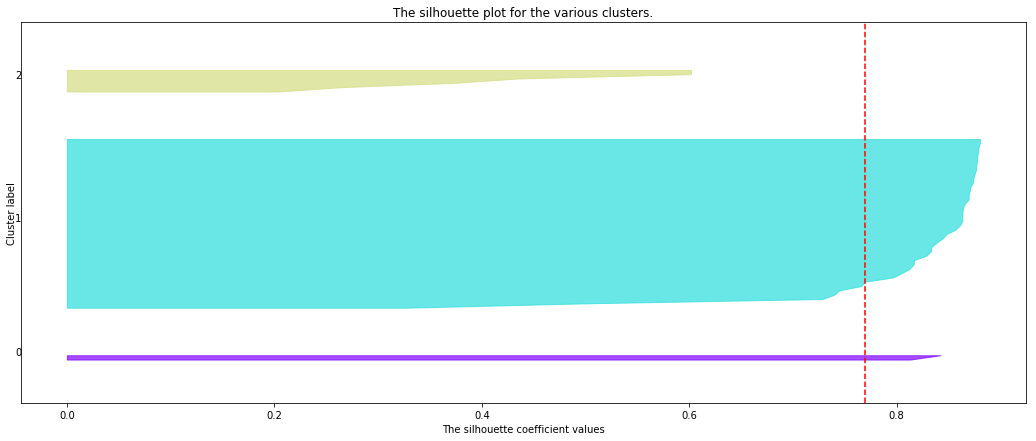

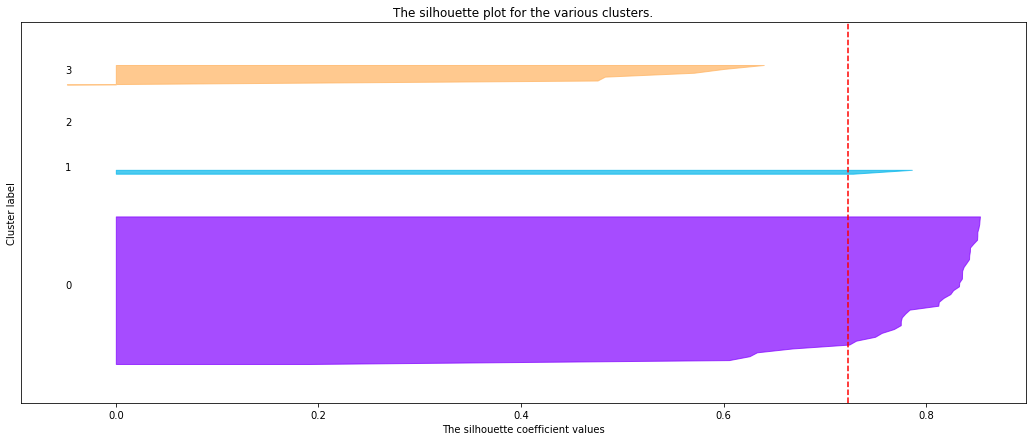

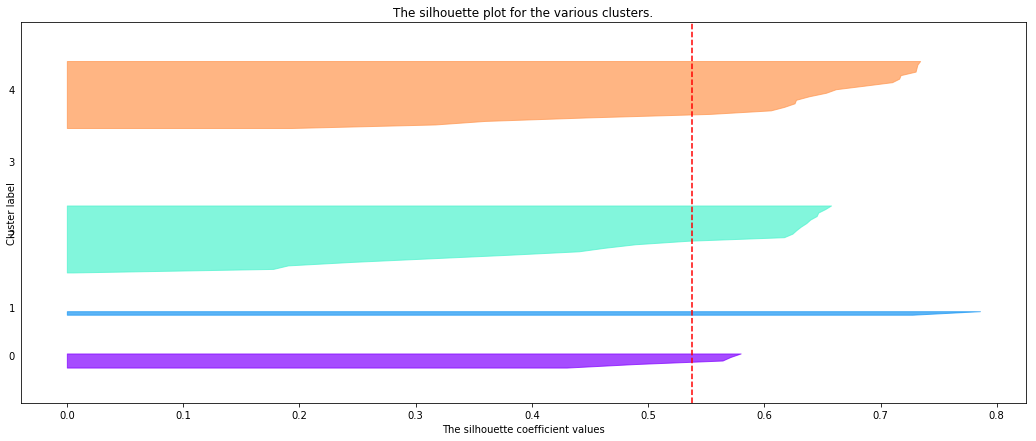

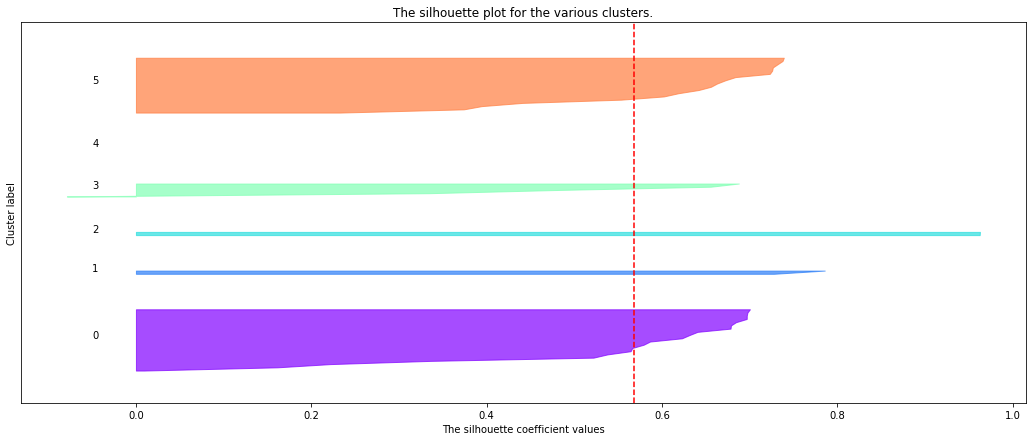

In [30]:
clusters = [2, 3, 4, 5, 6]
plot_silhouette(MV, clusters)

For n_clusters = 2 The average silhouette_score is : 0.3421432437188295
For n_clusters = 3 The average silhouette_score is : 0.16845333754658642
For n_clusters = 4 The average silhouette_score is : 0.15607170893012778
For n_clusters = 5 The average silhouette_score is : 0.09072067860416407
For n_clusters = 6 The average silhouette_score is : 0.0867688056369051


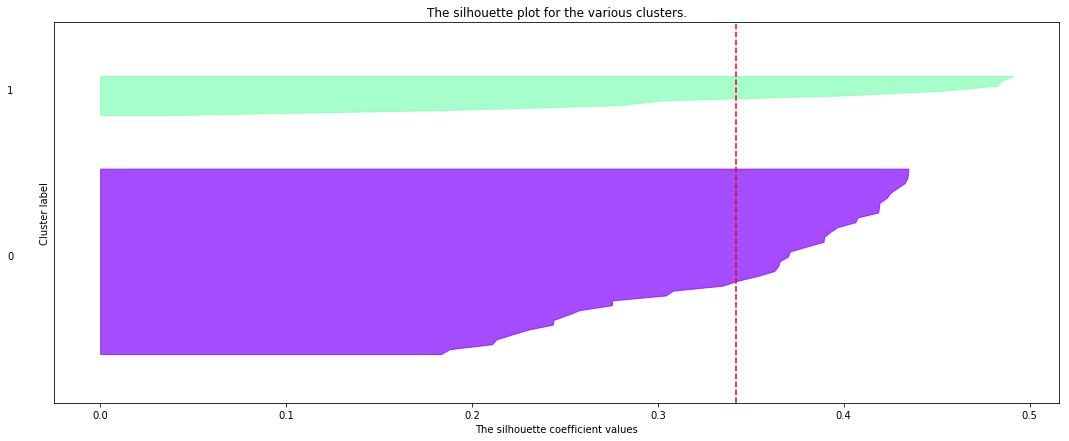

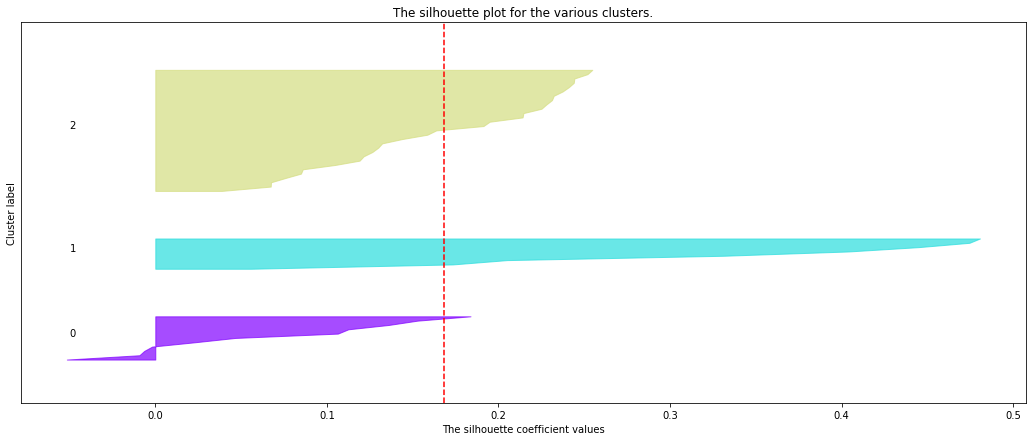

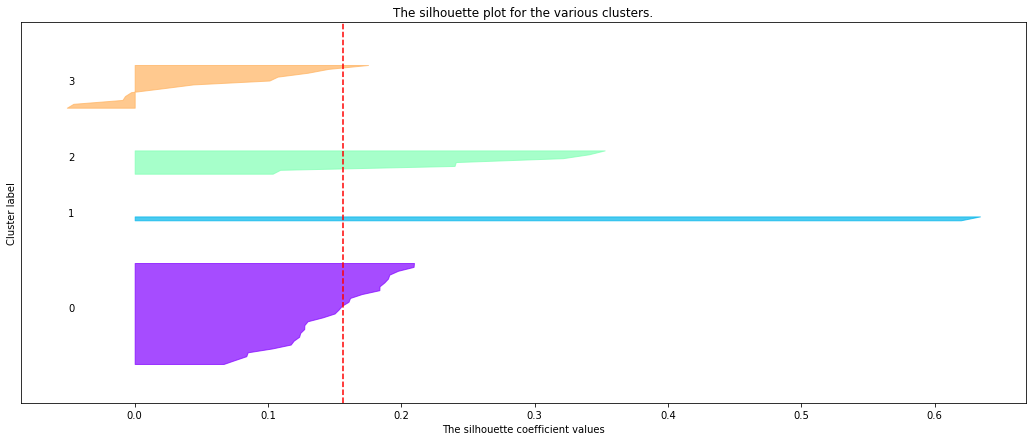

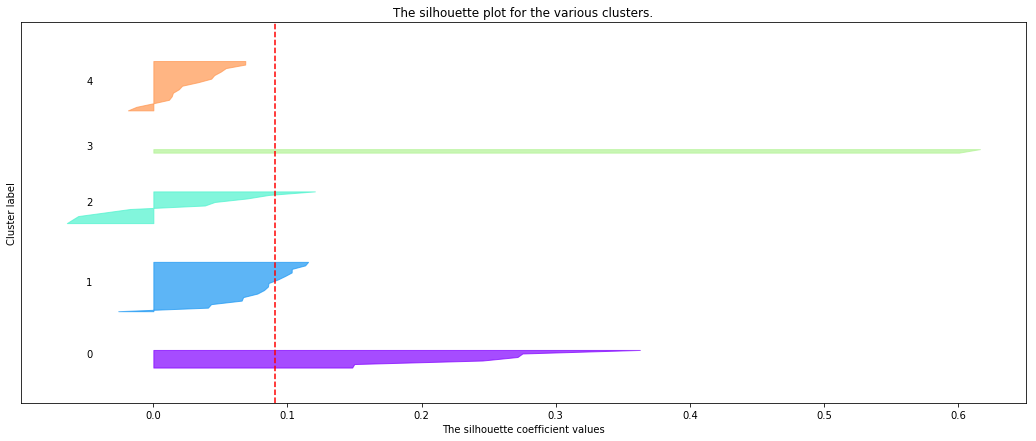

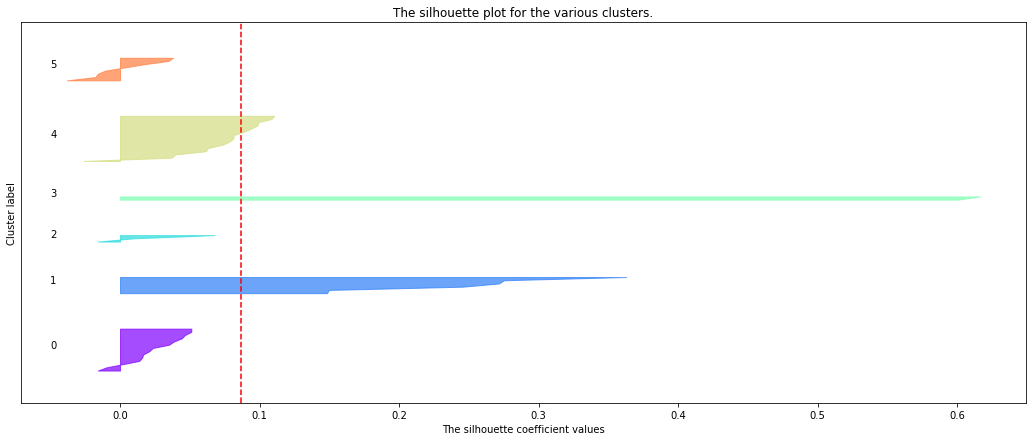

In [31]:
plot_silhouette(MI, clusters)

For n_clusters = 2 The average silhouette_score is : 0.3492227535135632
For n_clusters = 3 The average silhouette_score is : 0.203359781202633
For n_clusters = 4 The average silhouette_score is : 0.20952492030185696
For n_clusters = 5 The average silhouette_score is : 0.1566631778873402
For n_clusters = 6 The average silhouette_score is : 0.08322788917560477


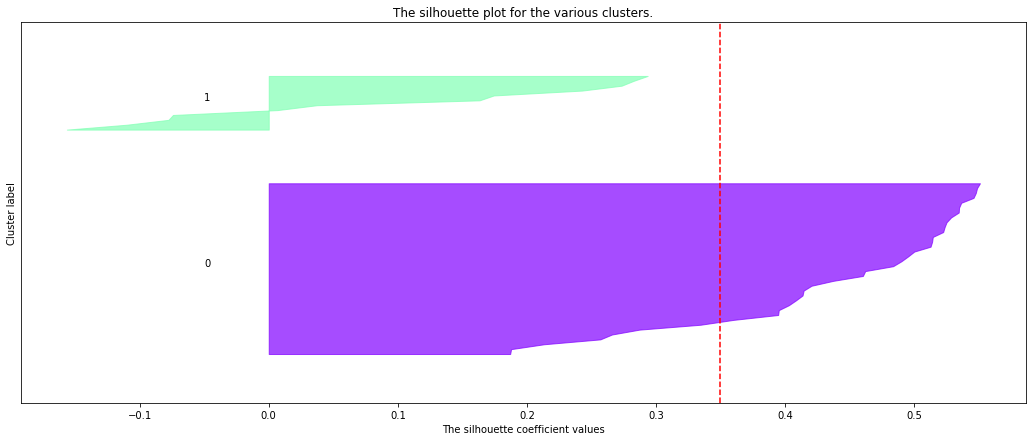

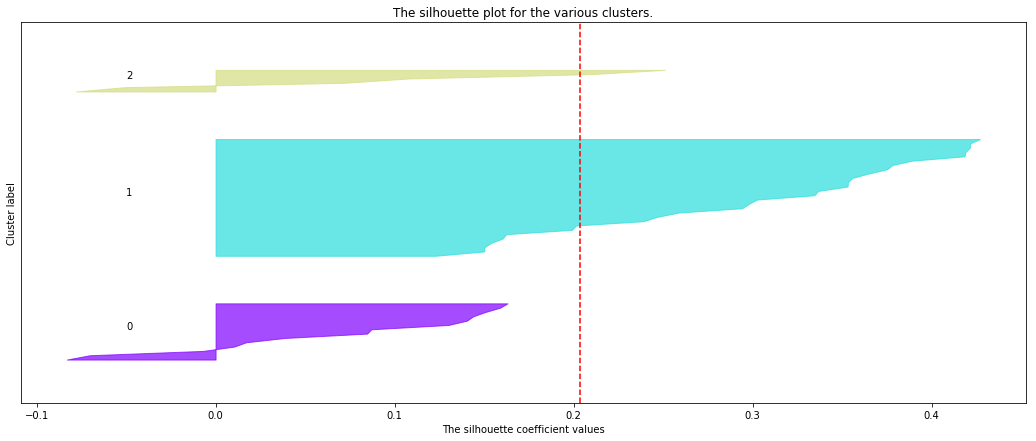

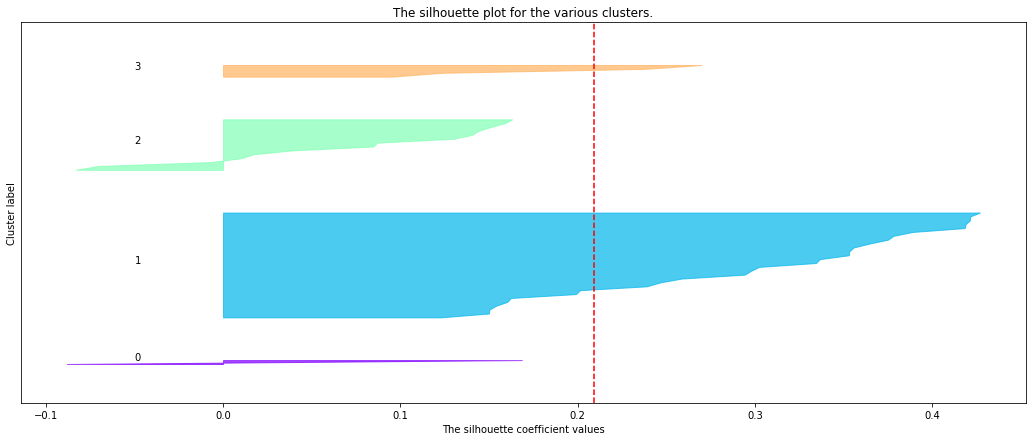

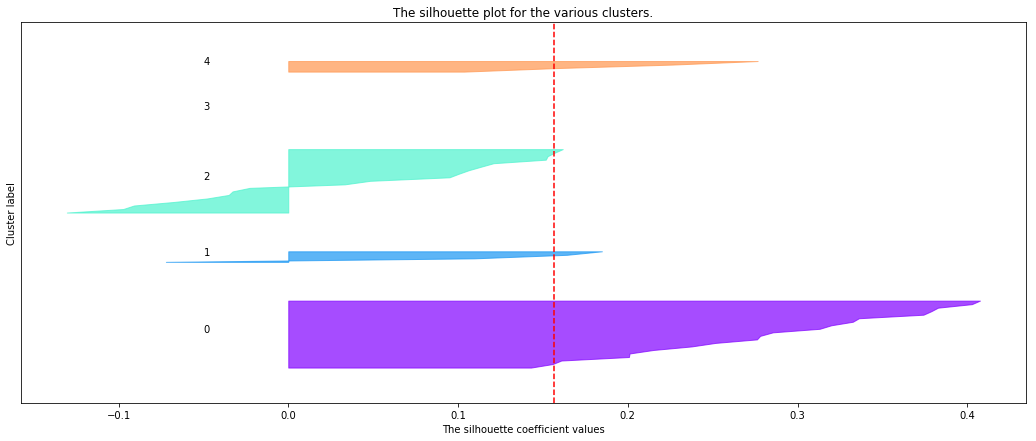

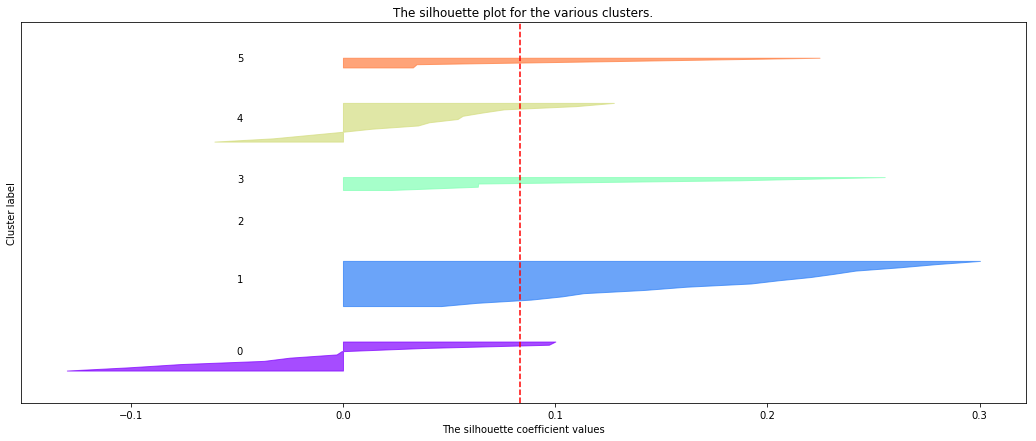

In [32]:
plot_silhouette(Ken, clusters)

For n_clusters = 2 The average silhouette_score is : 0.4853351265717227
For n_clusters = 3 The average silhouette_score is : 0.3579011165519795
For n_clusters = 4 The average silhouette_score is : 0.3742038020484261
For n_clusters = 5 The average silhouette_score is : 0.2091969137446191
For n_clusters = 6 The average silhouette_score is : 0.20586562736082395


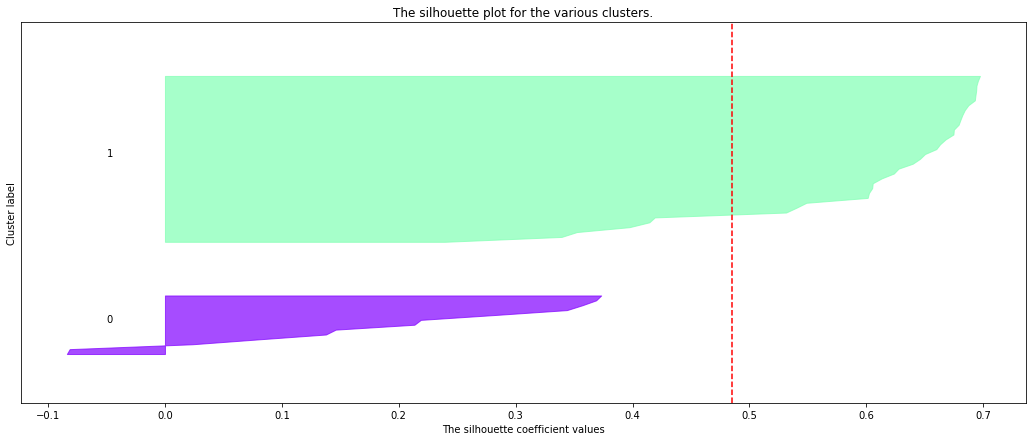

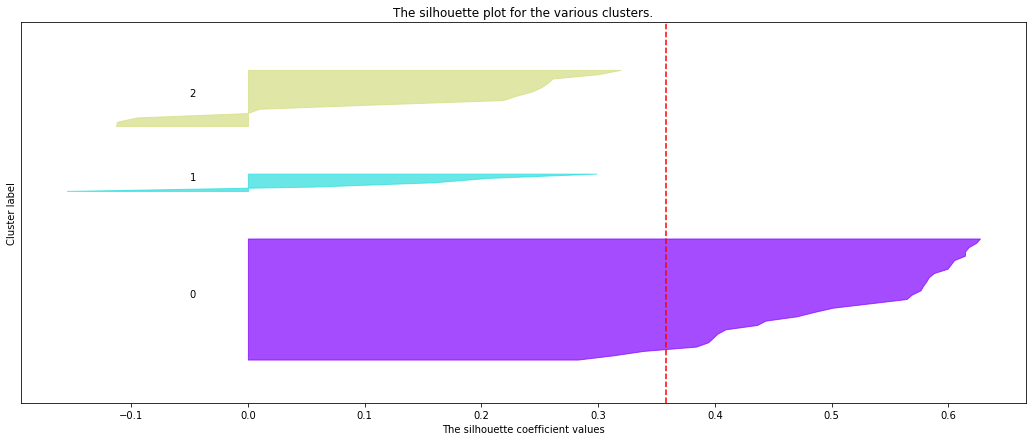

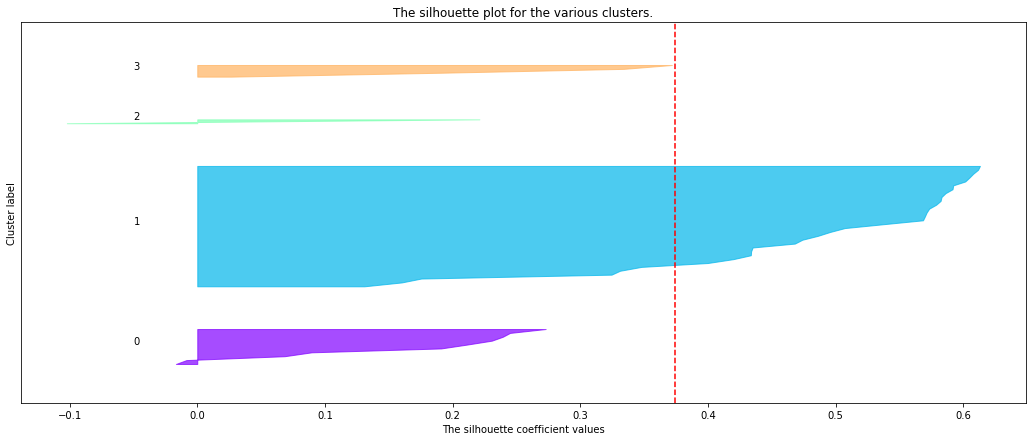

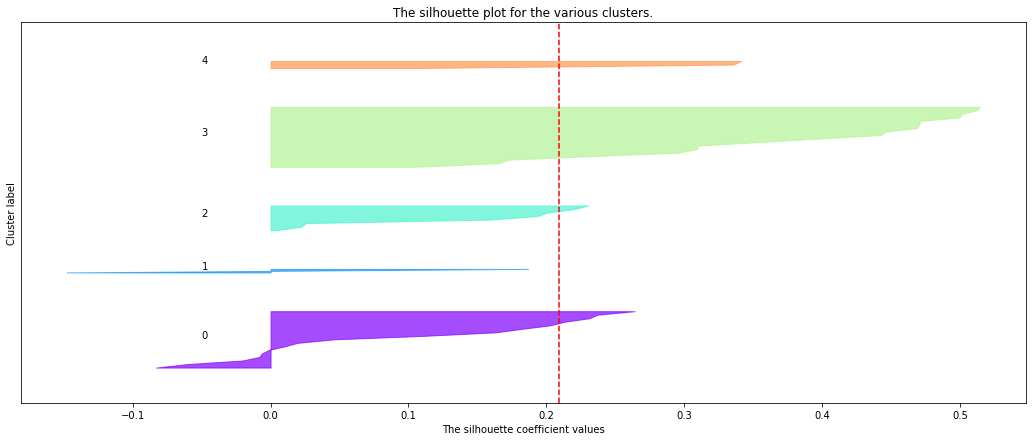

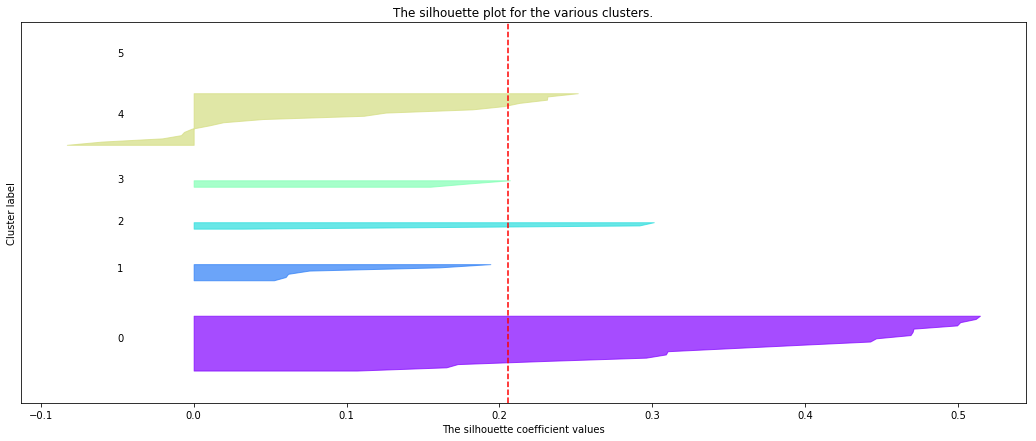

In [33]:
plot_silhouette(corr, clusters)

For n_clusters = 2 The average silhouette_score is : 0.5522263055052975
For n_clusters = 3 The average silhouette_score is : 0.32315490423551313
For n_clusters = 4 The average silhouette_score is : 0.30305461597332767
For n_clusters = 5 The average silhouette_score is : 0.2962213875183934
For n_clusters = 6 The average silhouette_score is : 0.16526172683860832


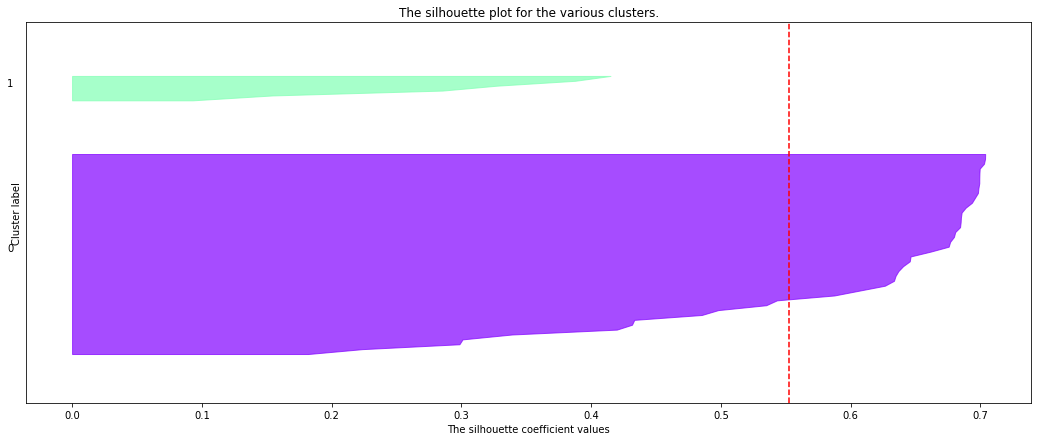

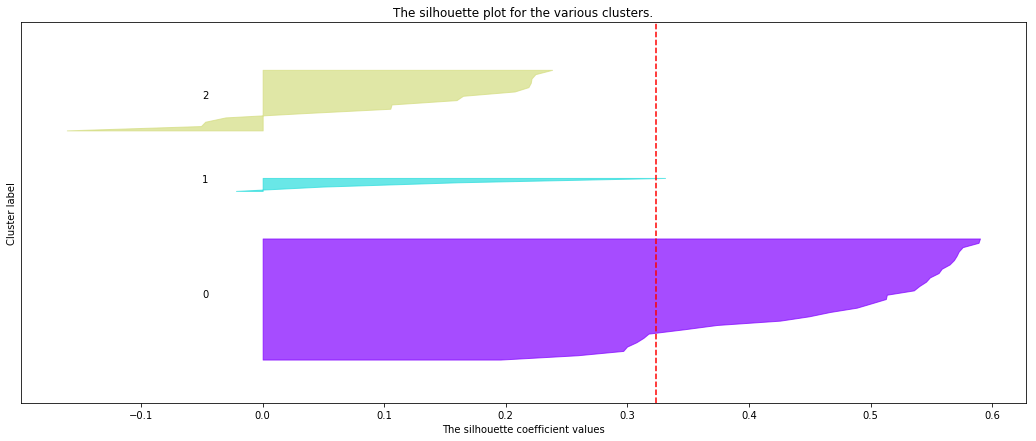

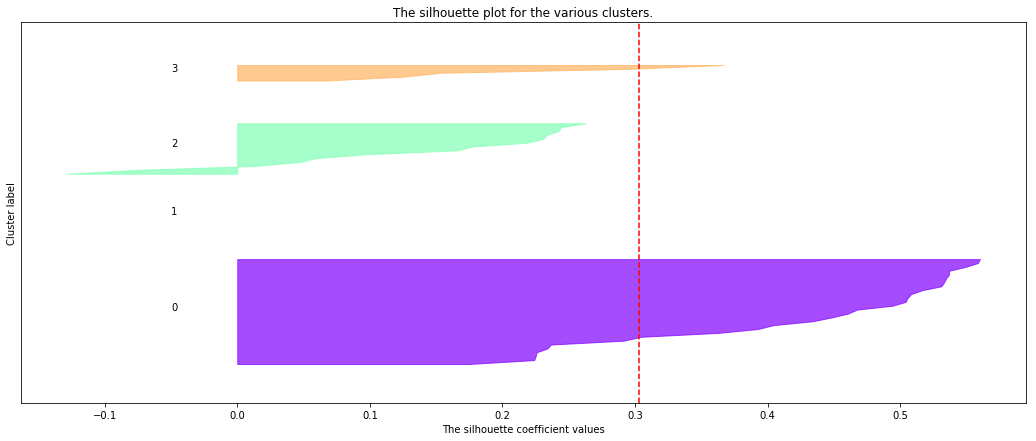

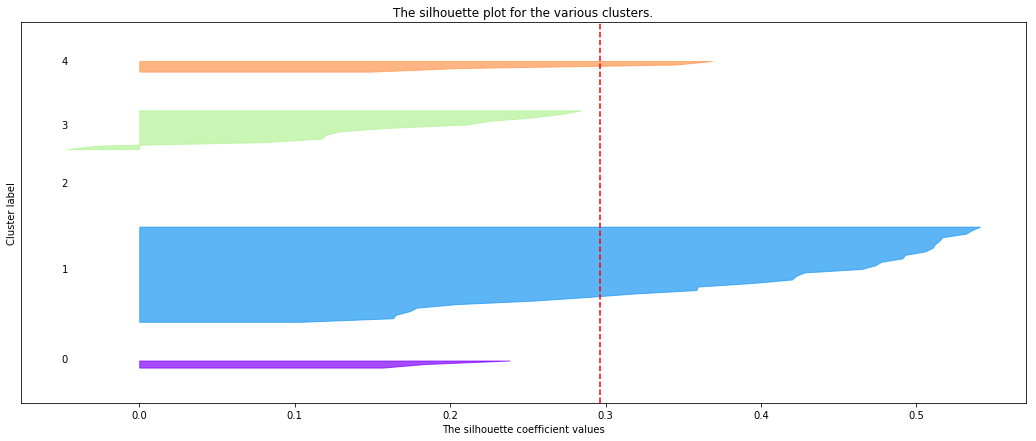

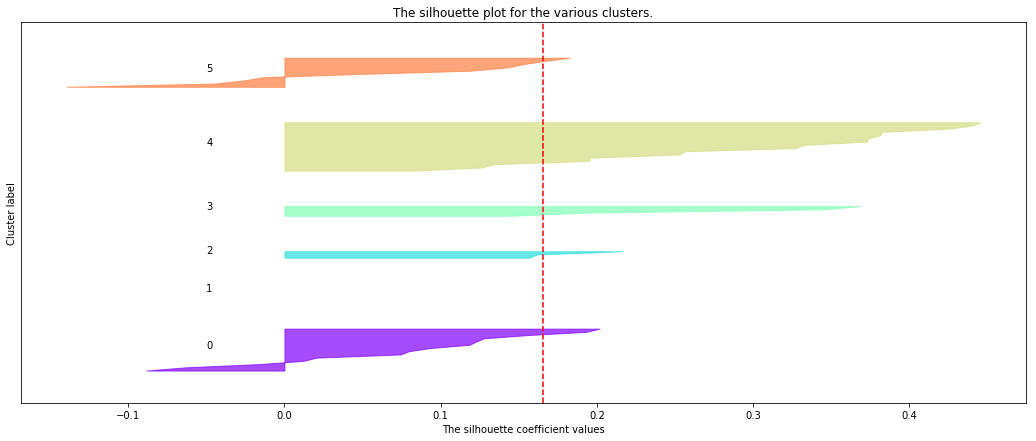

In [34]:
plot_silhouette(Spe, clusters)

For n_clusters = 2 The average silhouette_score is : 0.20435019590514306
For n_clusters = 3 The average silhouette_score is : 0.1578344343451715
For n_clusters = 4 The average silhouette_score is : 0.022587670268006798
For n_clusters = 5 The average silhouette_score is : 0.12627502970015914
For n_clusters = 6 The average silhouette_score is : 0.07682105925954409


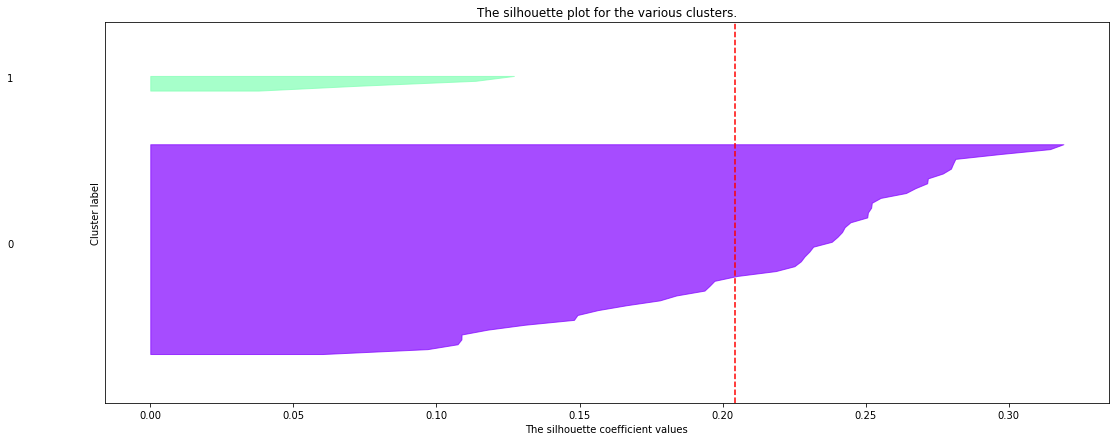

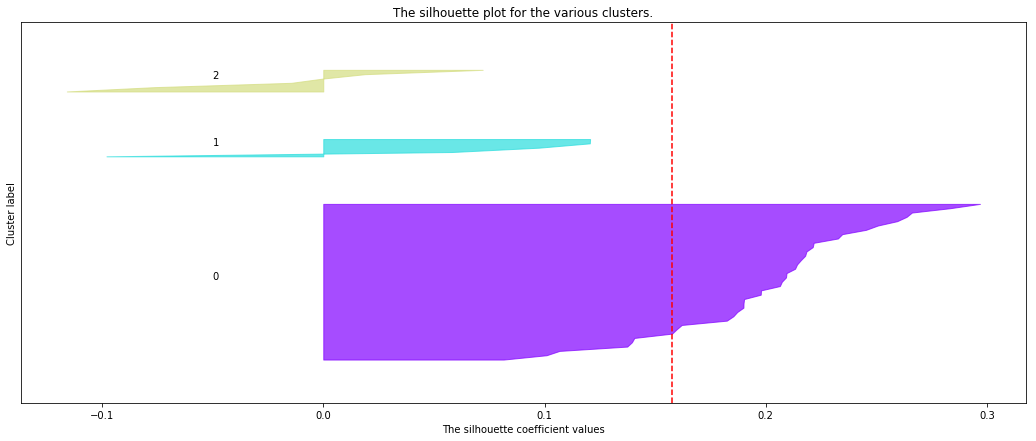

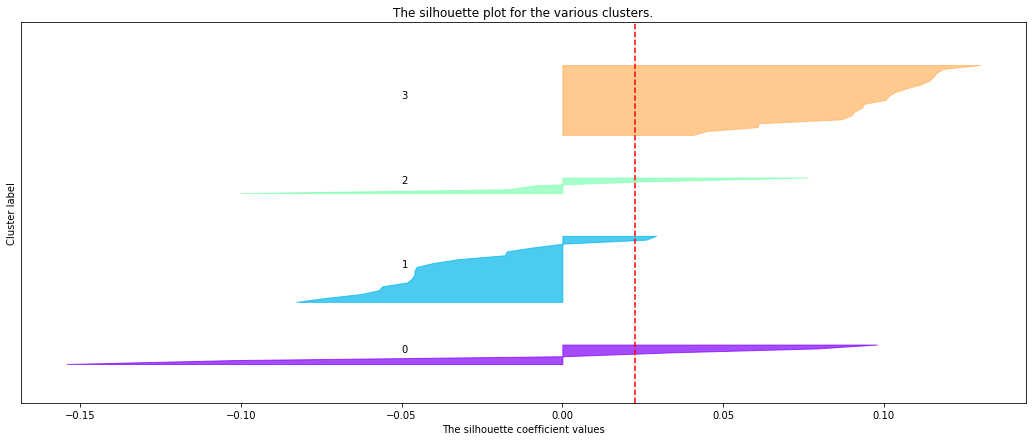

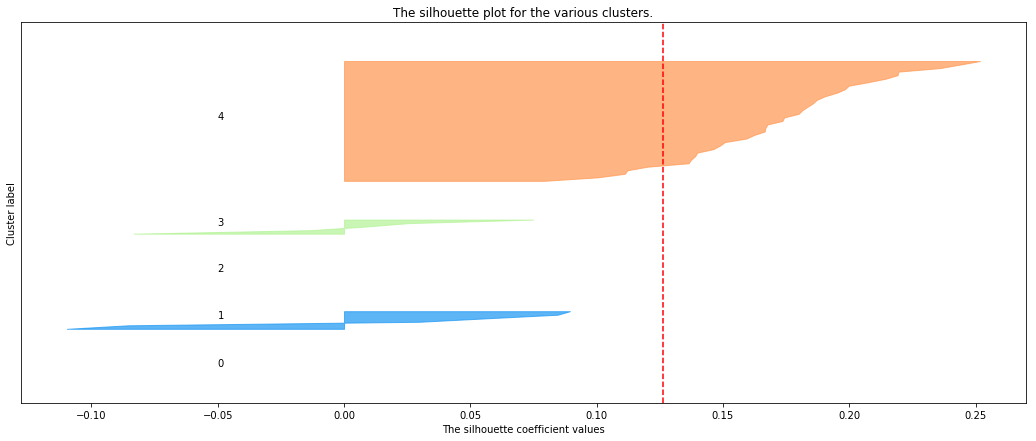

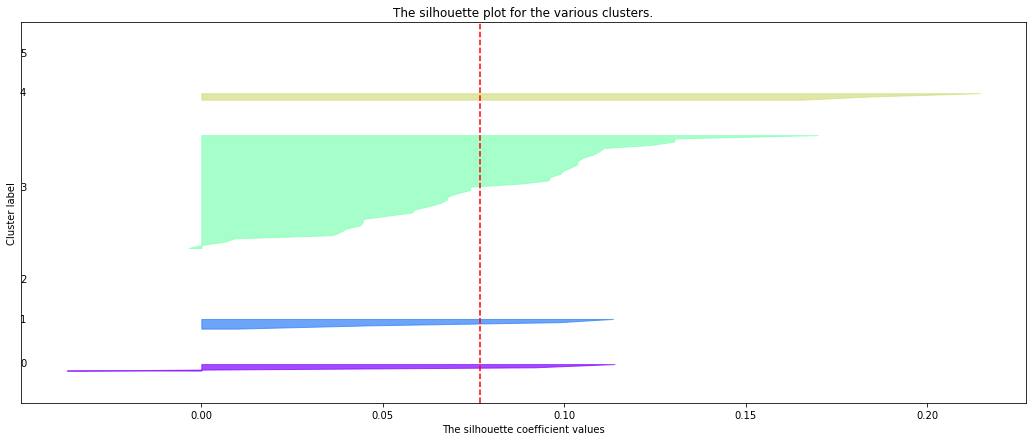

In [35]:
plot_silhouette(normdFY.T, clusters)

## Hierarchical cluster

In [37]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

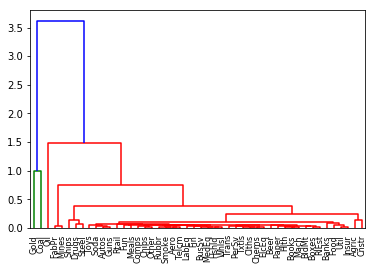

In [38]:
Z = hierarchy.linkage(MV, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=MV.index)

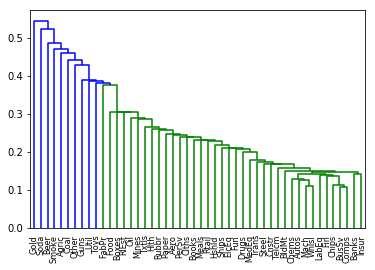

In [190]:
Z = hierarchy.linkage(normdFY.T, 'single', metric='correlation')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=normdFY.T.index)

## this is the corr distance it is using in package: 1-abs(corr)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage



In [113]:
def record_nodes_infor(Z):
    nodes = {}
    for i in range(48, 95):
        nodes[i] = list()
        for j in [0, 1]:
            if Z[i-48, j] <= 47:
                nodes[i].append(Z[i-48, j])
            elif (Z[i-48, j] > 47) & (Z[i-48, j] < i):
                nodes[i] = nodes[i]+nodes[Z[i-48, j]]
            else:
                print("Shit! Logic is wrong!!")
        nodes[i].sort()
    return nodes

In [185]:
record = {}
for re in range(48, 95):
    record[re] = 0
def update_counts(realN, bootN, counts=record):
    for c in range(48, 95):
        real = realN[c]
        reallen = len(real)
        for d in range(48, 95):
            if len(bootN[d]) == reallen:
                if np.all(np.asarray(bootN[d]) == np.asarray(real)):
                    counts[c] = counts[c] + 1


In [187]:
def cross_validation(data, method, metric, B):
    ZR = hierarchy.linkage(data.T, method=method, metric=metric)
    realN = record_nodes_infor(ZR)

    record = {}
    for re in range(48, 95):
        record[re] = 0
    for i in range(B):
        boot = data.sample(frac=1, replace=True, axis=0)
        ZB = hierarchy.linkage(boot.T, method=method, metric=metric)
        bootN = record_nodes_infor(ZB)
        update_counts(realN, bootN, counts=record)

    return record

In [191]:
frequancy = cross_validation(normdFY, method='single', metric='correlation', B=1000)

In [193]:
keep = list()
for key in frequancy.keys():
    if frequancy[key] >= 700:
        keep.append(key)
keep

[48, 49, 50, 52, 58, 63, 83, 92, 93, 94]

## want to use link_color_func=lambda k: color[k], but couldn't work out how

stableZ = Z[np.asarray(keep)-48]
color = cm.rainbow(np.ones(Z.shape[0]+50)*0.7)
#color[np.asarray(keep)-48] = cm.rainbow(0.3)

In [228]:
%matplotlib tk

In [253]:
plt.figure()
dn = hierarchy.dendrogram(Z, distance_sort='descending', labels=normdFY.T.index)
plt.plot(dn['icoord'][0][2], dn['dcoord'][0][2], 'or')
#plt.annotate("big", (dn['icoord'][0][1], dn['dcoord'][0][2]), xytext=(0, -5),
                             #textcoords='offset points',
                             #va='top', ha='center')

In [238]:
dn

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 0.10966132418516406, 0.10966132418516406, 0.0],
  [0.0, 0.1264540374792127, 0.1264540374792127, 0.10966132418516406],
  [0.0, 0.12928696239246362, 0.12928696239246362, 0.1264540374792127],
  [0.0, 0.10808572015706064, 0.10808572015706064, 0.0],
  [0.0, 0.11371970437103707, 0.11371970437103707, 0.10808572015706064],
  [0.0, 0.13593069009798864, 0.13593069009798864, 0.11371970437103707],
  [0.0, 0.13906021119467193, 0.13906021119467193, 0.13593069009798864],
  [0.12928696239246362,
   0.1411785576378778,
   0.1411785576378778,
   0.13906021119467193],
  [0.0, 0.14314156856257965, 0.14314156856257965, 0.0],
  [0.1411785576378778,
   

In [240]:
Z

array([[33.        , 34.        ,  0.10808572,  2.        ],
       [20.        , 40.        ,  0.10966132,  2.        ],
       [35.        , 48.        ,  0.1137197 ,  3.        ],
       [22.        , 49.        ,  0.12645404,  3.        ],
       [13.        , 51.        ,  0.12928696,  4.        ],
       [46.        , 50.        ,  0.13593069,  4.        ],
       [36.        , 53.        ,  0.13906021,  5.        ],
       [52.        , 54.        ,  0.14117856,  9.        ],
       [43.        , 44.        ,  0.14314157,  2.        ],
       [55.        , 56.        ,  0.14739975, 11.        ],
       [16.        , 57.        ,  0.14892997, 12.        ],
       [31.        , 58.        ,  0.15896452, 13.        ],
       [17.        , 59.        ,  0.16911233, 14.        ],
       [18.        , 60.        ,  0.16921286, 15.        ],
       [39.        , 61.        ,  0.17244678, 16.        ],
       [11.        , 62.        ,  0.17982647, 17.        ],
       [12.        , 63.

In [241]:
normdFY.columns[34]

'Comps'